# Plant Identification using Long Short-Term Memory (LSTM)

This notebook uses a LSTM architectuee to *try* to identify plants in images, with a list of possible plant species from the dataset directory. LSTM's are normally used for natural language processing and speech recognition, so this shouldn't work well.


## Step 1: Import Libraries and Set Up


In [1]:
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable


In [21]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LSTM
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
import os
from collections import defaultdict

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.20.0


## Step 2: Get Plant Classes from Directory Names

Based on the real_model.ipynb approach, we'll get all possible plant species from the dataset directory.


In [22]:
# Set up paths (same as real_model.ipynb)
train_dir = "../datasets/dataset-test"

# Get the list of plant classes from directory names
# Each subdirectory represents a different plant class
class_names = sorted([d for d in os.listdir(train_dir) 
                      if os.path.isdir(os.path.join(train_dir, d))])
num_classes = len(class_names)

print(f"Found {num_classes} plant classes")
print(f"\nAll possible plant species:")
for i, name in enumerate(class_names, 1):
    print(f"{i:2d}. {name}")


Found 62 plant classes

All possible plant species:
 1. Alfalfa
 2. Asparagus
 3. Blue Vervain
 4. Broadleaf Plantain
 5. Bull Thistle
 6. Cattail
 7. Chickweed
 8. Chicory
 9. Cleavers
10. Coltsfoot
11. Common Sow Thistle
12. Common Yarrow
13. Coneflower
14. Creeping Charlie
15. Crimson Clover
16. Curly Dock
17. Daisy Fleabane
18. Dandellion
19. Downy Yellow Violet
20. Elderberry
21. Evening Primrose
22. Fern Leaf Yarrow
23. Field Pennycress
24. Fireweed
25. Forget Me Not
26. Garlic Mustard
27. Harebell
28. Henbit
29. Herb Robert
30. Japanese Knotweed
31. Joe Pye Weed
32. Knapweed
33. Kudzu
34. Lambs Quarters
35. Mallow
36. Mayapple
37. Meadowsweet
38. Milk Thistle
39. Mullein
40. New England Aster
41. Partridgeberry
42. Peppergrass
43. Pickerelweed
44. Pineapple Weed
45. Prickly Pear Cactus
46. Purple Deadnettle
47. Queen Annes Lace
48. Red Clover
49. Sheep Sorrel
50. Shepherds Purse
51. Spring Beauty
52. Sunflower
53. Supplejack Vine
54. Tea Plant
55. Teasel
56. Toothwort
57. Vervai

## Step 3: Load Image Function

Function to load images (based on real_model.ipynb approach).


In [23]:
from load_images import load_and_preprocess_image

# Load and preprocess the data (if needed elsewhere, use the generator from load_images.py)
# X, y = load_data(train_dir, class_names)
# X = preprocess_data(X)
# print(f"Loaded {X.shape[0]} images with shape {X.shape[1:]}")
# print(f"Loaded {y.shape[0]} labels with shape {y.shape[1:]}")

def load_image(image_path):
    """
    Load and preprocess an image from file path using the custom loader.
    Returns a numpy array (224x224x3, normalized, aspect ratio preserved)
    """
    return load_and_preprocess_image(image_path)


## Step 3.5: Identify Plants using an LSTM Model

Function to identify plants an LSTM Model with the list of possible plant species.


In [52]:
def load_model_lstm(model_path='comparison_model_lstm.h5'):
    """
    Load the pre-trained LSTM model from file.
    """ 
    ### IMPORTANT NOTE IMPORTANT NOTE ###
    # I honestly have no idea what happened here,
    # I was running into version errors with TensorFlow/Keras
    # and this was the only way I could get the model to load properly.
    # So, THIS WEIRD INNER CLASS STUFF WAS GENERATED WITH GEMINI.
    # THE LSTM MODEL IS STILL MY WORK, BUT THIS PATCHING IS NOT.
    class PatchedLSTM(LSTM):
        def __init__(self, *args, **kwargs):
            kwargs.pop('time_major', None)
            super().__init__(*args, **kwargs)

    def expand_dims_layer(x):
        return tf.expand_dims(x, axis=1)
    model = keras.models.load_model(
        'comparison_model_lstm.h5',
        safe_mode=False,
        custom_objects={
            'LSTM': PatchedLSTM,
            'expand_dims_layer': expand_dims_layer
        }
    )
    return model


def identify_plant_lstm(image_path, class_names, model):
    """
    Identify a plant in an image using an LSTM Model.
    """

    img_array = load_and_preprocess_image(image_path)
    img_array = np.expand_dims(img_array, axis=0)


    predictions = model.predict(img_array, verbose=0)
    predicted_index = np.argmax(predictions, axis=1)[0]
    
    if predicted_index < len(class_names):
        predicted_plant = class_names[predicted_index]
    else:
        predicted_plant = "Unknown (Index Error)"

    return predicted_plant

## Step 3.6: Test with a Single Image

Before running the full dataset evaluation, let's test with one image to make sure everything works!


In [54]:
import glob
import random

model = load_model_lstm()

def get_random_test_image(test_dir="../datasets/dataset-test", class_name=None):
    """
    Get a random test image from the dataset.
    
    Args:
        test_dir: Directory containing test images
        class_name: Optional - specific plant class to get image from
    
    Returns:
        Tuple: (path to image file, true class name)
    """
    if class_name:
        # Get image from specific class
        class_dir = os.path.join(test_dir, class_name)
        if not os.path.isdir(class_dir):
            raise ValueError(f"Class directory not found: {class_dir}")
    else:
        # Get random class
        all_classes = [d for d in os.listdir(test_dir) 
                       if os.path.isdir(os.path.join(test_dir, d))]
        if not all_classes:
            raise ValueError(f"No classes found in {test_dir}")
        class_name = random.choice(all_classes)
        class_dir = os.path.join(test_dir, class_name)
    
    image_files = []
    for ext in ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG']:
        image_files.extend(glob.glob(os.path.join(class_dir, ext)))
    
    if not image_files:
        raise ValueError(f"No images found in {class_dir}")
    
    return random.choice(image_files), class_name

# Test with a single random image
print("=" * 60)
print("TESTING LSTM MODEL WITH A SINGLE IMAGE")
print("=" * 60)

test_image_path, true_class = get_random_test_image()

# Display the image
img = load_image(test_image_path)
display(img)  # In Jupyter, this will show the image
    
# Identify the plant using LSTM model

predicted_name = identify_plant_lstm(test_image_path, class_names, model)

print("-" * 60)
print(f"Predicted: {predicted_name}")
print(f"True class: {true_class}")
print(f"Match: {'Correct!' if predicted_name == true_class else 'Incorrect'}")
print("-" * 60)


/home/ad.msoe.edu/myersjr/.local/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


TESTING LSTM MODEL WITH A SINGLE IMAGE


array([[[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       ...,

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]]], shape=(224, 224, 3), dtype=float32)

------------------------------------------------------------
Predicted: Sunflower
True class: Evening Primrose
Match: Incorrect
------------------------------------------------------------


## Step 4: Evaluate Gemini on Entire Test Dataset

Evaluate Gemini API on all test images and calculate accuracy.


In [55]:
import glob
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

def evaluate_lstm_on_dataset(class_names, test_dir):
    """
    Evaluate LSTM model on all test images in the dataset.
    
    Args:
        test_dir: Directory containing test images (organized by class)
        class_names: List of class names in order
    
    Returns:
        Dictionary with evaluation results
    """
    print("=" * 60)
    print("EVALUATING LSTM MODEL ON TEST DATASET")
    print("=" * 60)
    
    # Collect all test images with their true labels
    test_images = []
    true_labels = []
    
    for class_idx, class_name in enumerate(class_names):
        class_dir = os.path.join(test_dir, class_name)
        if not os.path.isdir(class_dir):
            continue
        
        # Find all image files
        image_files = []
        for ext in ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG']:
            image_files.extend(glob.glob(os.path.join(class_dir, ext)))
        
        # Add to test set
        for img_path in image_files:
            test_images.append(img_path)
            true_labels.append(class_idx)
    
    print(f"\nTesting on {len(test_images)} images...")
    
    # Get predictions for all test images
    predicted_labels = []
    correct_predictions = []
    
    for i, (img_path, true_label) in enumerate(zip(test_images, true_labels)):
        if (i + 1) % 10 == 0:
            print(f"  Processed {i + 1}/{len(test_images)} images...")
        
        # Get prediction using LSTM model
        predicted_name = identify_plant_lstm(img_path, class_names, model)
        
        # Convert plant name to index
        if predicted_name and predicted_name in class_names:
            predicted_idx = class_names.index(predicted_name)
        else:
            # If not found or None, assign a dummy index (will be counted as wrong)
            predicted_idx = -1  # We'll handle this in accuracy calculation
        
        predicted_labels.append(predicted_idx)
        correct_predictions.append(predicted_idx == true_label)
    
    # Calculate accuracy
    accuracy = sum(correct_predictions) / len(correct_predictions) if correct_predictions else 0.0
    
    # Per-class accuracy
    class_correct = defaultdict(int)
    class_total = defaultdict(int)
    
    for true_label, pred_label in zip(true_labels, predicted_labels):
        class_total[true_label] += 1
        if true_label == pred_label:
            class_correct[true_label] += 1
    
    per_class_accuracy = {}
    for class_idx in range(len(class_names)):
        if class_total[class_idx] > 0:
            per_class_accuracy[class_names[class_idx]] = (
                class_correct[class_idx] / class_total[class_idx]
            )
        else:
            per_class_accuracy[class_names[class_idx]] = 0.0
    
    # Build results dictionary
    results = {
        'accuracy': accuracy,
        'total_images': len(test_images),
        'correct': sum(correct_predictions),
        'per_class_accuracy': per_class_accuracy,
        'true_labels': true_labels,
        'predicted_labels': predicted_labels,
        'test_images': test_images
    }
    
    return results

# Run evaluation
test_dir = "../datasets/dataset-test"
test_results = evaluate_lstm_on_dataset(class_names, test_dir)

print(f"\n{'='*60}")
print(f"FINAL RESULTS")
print(f"{'='*60}")
print(f"Overall Accuracy: {test_results['accuracy']:.2%}")
print(f"Correct Predictions: {test_results['correct']}/{test_results['total_images']}")
print(f"\nEvaluation complete!")


EVALUATING LSTM MODEL ON TEST DATASET

Testing on 310 images...
  Processed 10/310 images...
  Processed 20/310 images...
  Processed 30/310 images...
  Processed 40/310 images...
  Processed 50/310 images...
  Processed 60/310 images...
  Processed 70/310 images...
  Processed 80/310 images...
  Processed 90/310 images...
  Processed 100/310 images...
  Processed 110/310 images...
  Processed 120/310 images...
  Processed 130/310 images...
  Processed 140/310 images...
  Processed 150/310 images...
  Processed 160/310 images...
  Processed 170/310 images...
  Processed 180/310 images...
  Processed 190/310 images...
  Processed 200/310 images...
  Processed 210/310 images...
  Processed 220/310 images...
  Processed 230/310 images...
  Processed 240/310 images...
  Processed 250/310 images...
  Processed 260/310 images...
  Processed 270/310 images...
  Processed 280/310 images...
  Processed 290/310 images...
  Processed 300/310 images...
  Processed 310/310 images...

FINAL RESULTS


## Step 5: Confusion Matrix

Create a confusion matrix similar to real_model.ipynb to visualize the results.


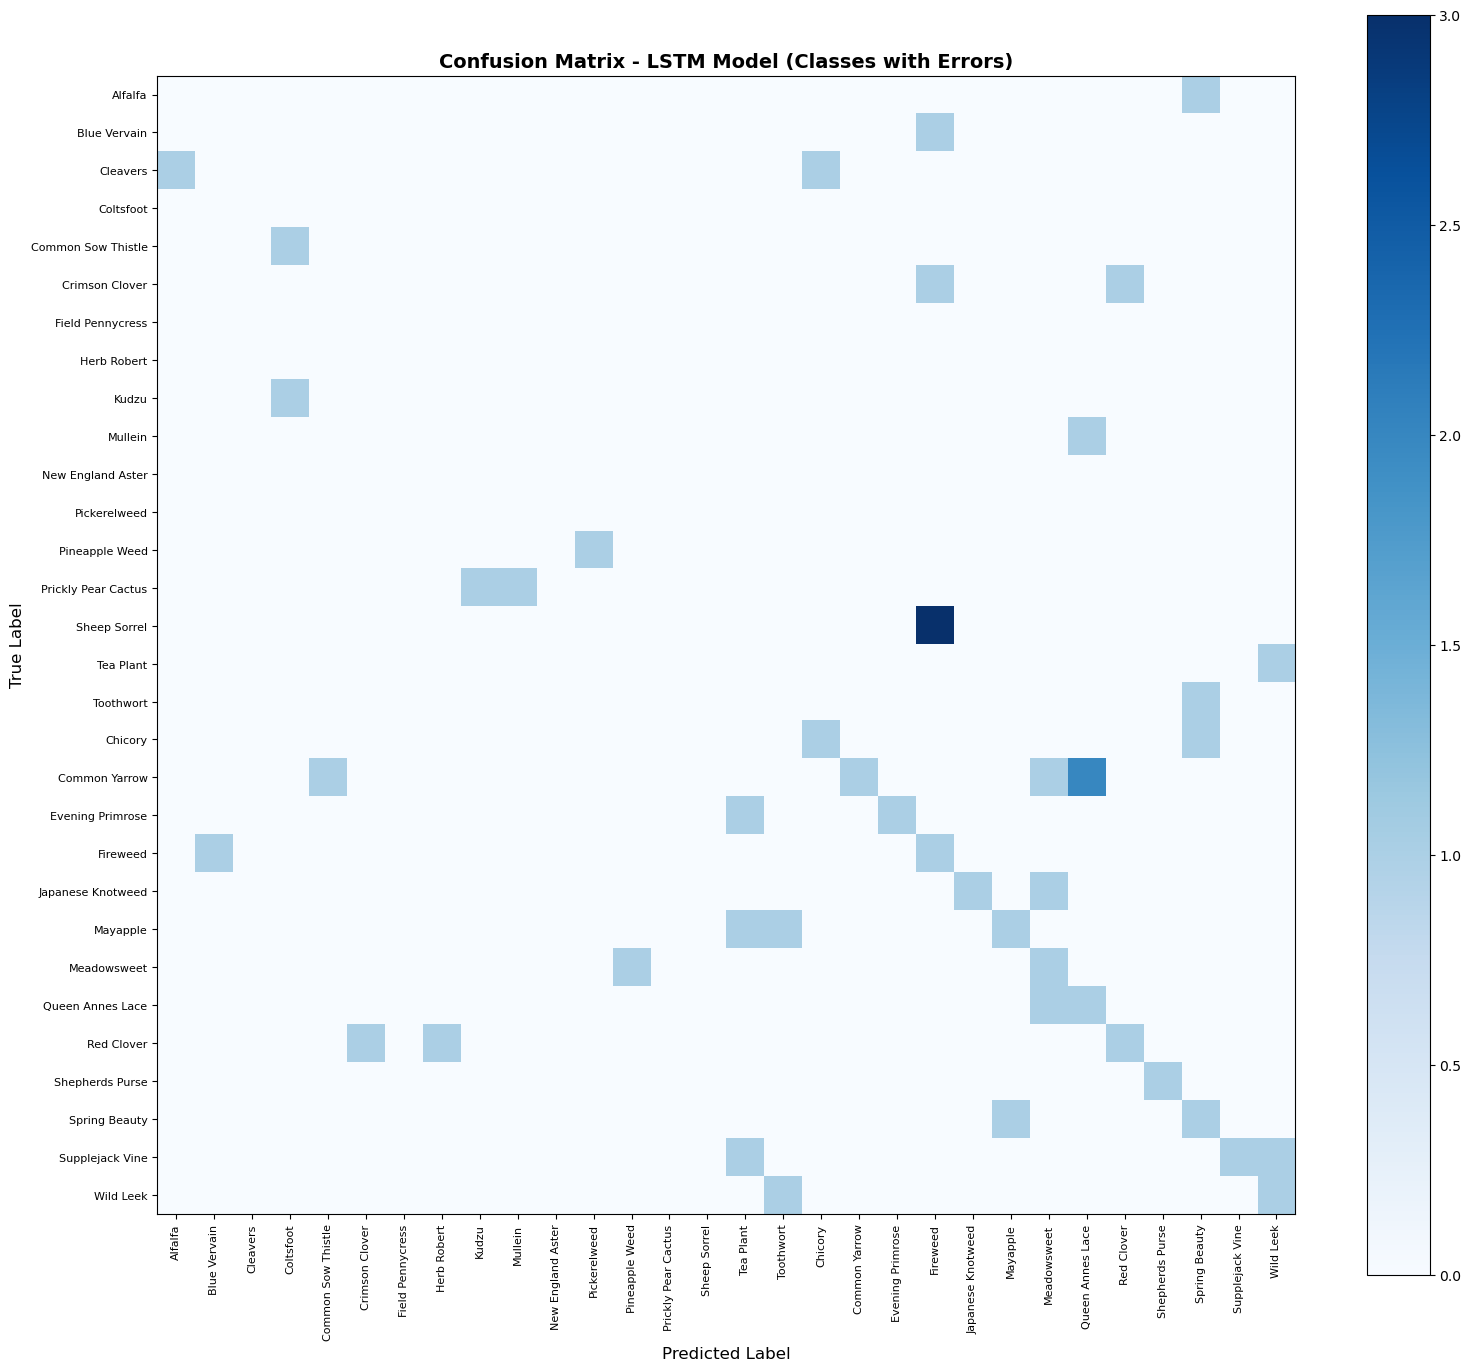


Classification Report:
                     precision    recall  f1-score   support

            Alfalfa       0.00      0.00      0.00         5
          Asparagus       0.80      0.80      0.80         5
       Blue Vervain       0.00      0.00      0.00         5
 Broadleaf Plantain       1.00      0.40      0.57         5
       Bull Thistle       0.67      0.40      0.50         5
            Cattail       0.75      0.60      0.67         5
          Chickweed       0.17      0.40      0.24         5
            Chicory       0.50      0.20      0.29         5
           Cleavers       0.00      0.00      0.00         5
          Coltsfoot       0.00      0.00      0.00         5
 Common Sow Thistle       0.00      0.00      0.00         5
      Common Yarrow       1.00      0.20      0.33         5
         Coneflower       1.00      0.80      0.89         5
   Creeping Charlie       0.50      0.40      0.44         5
     Crimson Clover       0.00      0.00      0.00         5

In [58]:
# Handle predictions that are -1 (not found in class list) by mapping them to a dummy class
# For confusion matrix, we'll only include valid predictions
valid_indices = [i for i, pred in enumerate(test_results['predicted_labels']) if pred >= 0]
true_labels_valid = [test_results['true_labels'][i] for i in valid_indices]
predicted_labels_valid = [test_results['predicted_labels'][i] for i in valid_indices]

# Create confusion matrix
cm = confusion_matrix(true_labels_valid, predicted_labels_valid, labels=range(len(class_names)))

# Plot confusion matrix (similar to real_model.ipynb)
plt.figure(figsize=(16, 14))

# Find classes with at least one error
error_classes = []
for i in range(len(class_names)):
    row_sum = cm[i].sum()
    if row_sum > 0:  # Has test samples
        errors = row_sum - cm[i, i]  # Total - correct
        if errors > 0:  # Has errors
            error_classes.append(i)

# Show top 30 classes with errors, or all if less than 30
if len(error_classes) > 30:
    # Sort by number of errors
    error_counts = [(i, cm[i].sum() - cm[i, i]) for i in error_classes]
    error_counts.sort(key=lambda x: x[1], reverse=True)
    error_classes = [x[0] for x in error_counts[:30]]
    
    # Create subset confusion matrix
    cm_subset = cm[np.ix_(error_classes, error_classes)]
    class_names_subset = [class_names[i] for i in error_classes]
    
    plt.imshow(cm_subset, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    plt.xticks(range(len(class_names_subset)), class_names_subset, rotation=90, fontsize=8)
    plt.yticks(range(len(class_names_subset)), class_names_subset, fontsize=8)
    plt.title('Confusion Matrix - LSTM Model (Classes with Errors)', fontsize=14, fontweight='bold')
else:
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    plt.xticks(range(len(class_names)), class_names, rotation=90, fontsize=8)
    plt.yticks(range(len(class_names)), class_names, fontsize=8)
    plt.title('Confusion Matrix - Gemini API', fontsize=14, fontweight='bold')

plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('lstm_confusion_matrix.png')
plt.show()

# Print classification report
print("\nClassification Report:")
print("=" * 60)
print(classification_report(
    true_labels_valid,
    predicted_labels_valid,
    target_names=class_names,
    zero_division=0
))
